In [25]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import SVC

import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
import pandas as pd

import time
from tqdm import tqdm
import warnings


In [26]:
data = load_breast_cancer()

In [27]:
warnings.filterwarnings("ignore")

In [28]:
# Normalizar
X = MinMaxScaler().fit_transform(data.data)
y = data.target

X.shape, y.shape

((569, 30), (569,))

In [29]:
# Creación de 10 particiones para realizar validación cruzada
K=10
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)

In [34]:
inicial = time.time()
r_centros = pd.DataFrame(columns=['No.Centros', 'Aciertos Entrena', 'Aciertos Verifica'])
for a, k in tqdm(enumerate(range(2,31,1)), total=29, unit=" n_clusters" ):
    aciertos_entrena = 0.0
    aciertos_verifica = 0.0
    
    for train_index, test_index in skf.split(X,y):
        kmedias = KMeans(n_clusters=k)
        
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        kmedias.fit(X_train)
        label_training = kmedias.labels_
        label_cluster = np.zeros((k,), dtype=int) -1
        for i in range(k):
            label_cluster[i] = np.array(mode(y_train[np.argwhere(label_training == i)]))[0].astype(int)
        aciertos_entrena += accuracy_score(label_cluster[label_training], y_train)
        aciertos_verifica += accuracy_score(label_cluster[kmedias.predict(X_test)], y_test)
    r_centros.loc[a] = [k, aciertos_entrena/K, aciertos_verifica/K]
elapsed_time = time.time() - inicial
print("Tiempo =", elapsed_time, "sec.")


100%|█████████████████████████████████████████████████████████████████████████| 29/29 [00:39<00:00,  1.37s/ n_clusters]

Tiempo = 39.79794979095459 sec.


In [35]:
r_centros

,No.Centros,Aciertos Entrena,Aciertos Verifica
0,2.0,0.926576,0.927882
1,3.0,0.903339,0.899781
2,4.0,0.893578,0.892763
3,5.0,0.924428,0.926159
4,6.0,0.885960,0.883991
5,7.0,0.913888,0.912061
6,8.0,0.915840,0.901598
7,9.0,0.928144,0.912093
8,10.0,0.931849,0.915727
9,11.0,0.934781,0.924405


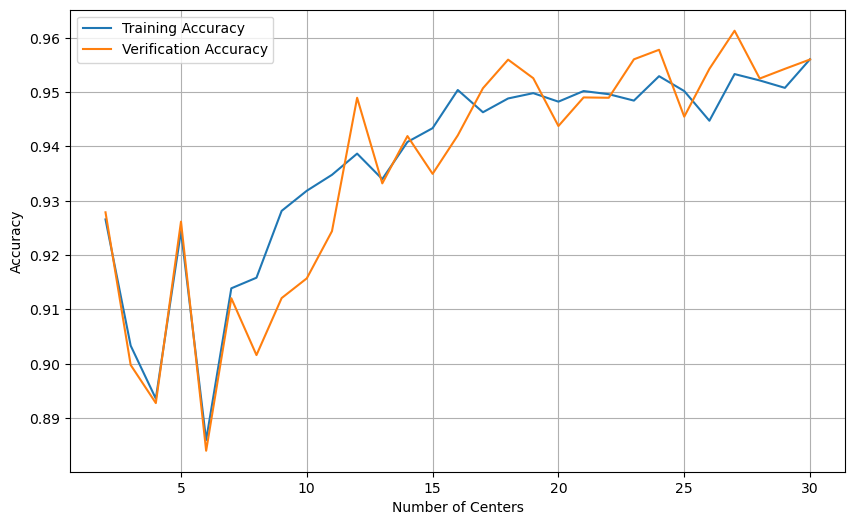

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(r_centros['No.Centros'], r_centros['Aciertos Entrena'], label='Training Accuracy')
plt.plot(r_centros['No.Centros'], r_centros['Aciertos Verifica'], label='Verification Accuracy')
plt.xlabel('Number of Centers')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
# Find the row with the highest verification accuracy
best_row = r_centros.loc[r_centros['Aciertos Verifica'].idxmax()]

# Get the number of centers for that row
best_k = best_row['No.Centros']
best_acierto_v = best_row['Aciertos Verifica']

print(f"La mayor tasa de acierto de verificación es con {int(best_k)} clusters, siendo de: {best_acierto_v}")


La mayor tasa de acierto de verificación es con 27 clusters, siendo de: 0.961309523809524


# Entrenamiento SVM


In [38]:
from scipy.spatial.distance import cdist

In [39]:
kmedias = KMeans(n_clusters=int(best_k))
kmedias.fit(X)
centros = kmedias.cluster_centers_
distancias = euclidean_distances(centros)
sigma = np.sum(distancias, axis=0)/(centros.shape[0]-1)
X_svm = np.exp(-cdist(X, kmedias.cluster_centers_)**2/(2*sigma**2))
X_svm.shape

(569, 27)

In [40]:
aciertos_svm_grado = pd.DataFrame(columns=['Grado','Aciertos'])
for k, g in enumerate(range(1,6)):
    aciertos_svm = []
    for train_index, test_index in skf.split(X_svm, y):
        svm = SVC(kernel='poly', degree = g, verbose=False)
        svm.fit(X_svm[train_index], y[train_index])
        aciertos_svm.append(svm.score(X_svm[test_index], y[test_index]))
    aciertos = np.mean(np.array(aciertos_svm))
    print("Grado:", g, "\t", aciertos)
    aciertos_svm_grado.loc[k] = [g, aciertos]

Grado: 1 	 0.9666040100250626
Grado: 2 	 0.9666040100250625
Grado: 3 	 0.9718671679197994
Grado: 4 	 0.9718984962406015
Grado: 5 	 0.9595864661654134


In [41]:
aciertos_svm_grado

,Grado,Aciertos
0,1.0,0.966604
1,2.0,0.966604
2,3.0,0.971867
3,4.0,0.971898
4,5.0,0.959586


In [42]:
# Find the row with the highest verification accuracy
best_row = aciertos_svm_grado.loc[aciertos_svm_grado['Aciertos'].idxmax()]

# Get the number of centers for that row
best_grado = best_row['Grado']
best_acierto = best_row['Aciertos']

print(f"La mayor tasa de aciertos es con un kernel polinómico de grado: {int(best_grado)} y su valor es: {best_acierto}")


La mayor tasa de aciertos es con un kernel polinómico de grado: 4 y su valor es: 0.9718984962406015


In [ ]:
kmedias=KMeans(n_clusters=5)
kmedias.fit(x)
centros=kmedias.cluster_centers_
distancia=euclidean_distances(centros)

sigma=np.sum(distancia,axis=0)/(centros.shape[0]-1)
X_svm= np.exp(-cdist(x, centros)**2/(2*sigma**2))


In [ ]:
svm=SVC(kernel='poly',degree=g)